In [1]:
# # Imports necessary libraries for API calls, data handling, time, and machine learning
# import requests
# import pandas as pd
# import numpy as np
# import pytz
# from datetime import datetime, timedelta
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
# from sklearn.metrics import mean_squared_error
# import requests

In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import random

# --- I. Mock ML Data Generator (Ensures Reusability) ---

def mock_ml_forecast_data(city_name):
    """
    Simulates the output of a Machine Learning model.
    CRITICAL: Returns data in the exact same structured list format as the API fetcher.
    """
    # Simple logic to generate slightly varied data based on the city
    base_temp = 30 if "Phnom Penh" in city_name else 25
    base_rain = 0.5 if "Phnom Penh" in city_name else 1.0

    today = datetime.now().date()
    ml_data = []

    # Generate 8 days of mock data (Current Day + Next 7 Days)
    for i in range(8):
        current_date = today + timedelta(days=i)
        
        # Add random noise to simulate prediction variance
        mean_temp = round(base_temp + random.uniform(-1.5, 1.5), 1)
        rain_mm = round(max(0, base_rain + random.uniform(-0.5, 1.5)), 1)
        
        # Determine description based on generated data
        if mean_temp > 30 and rain_mm < 0.2:
            description = "Clear sky"
        elif rain_mm > 1.0:
            description = "Light rain"
        else:
            description = "Scattered clouds"

        data_point = {
            "city": city_name,
            "date": current_date.strftime("%Y-%m-%d") + (" (Current)" if i == 0 else ""),
            "max_temp": round(mean_temp + random.uniform(2.5, 4.5), 1),
            "min_temp": round(mean_temp - random.uniform(2.5, 4.5), 1),
            "mean_temp": mean_temp,
            "rain_mm": rain_mm,
            "description": description
        }
        ml_data.append(data_point)
    return ml_data

In [3]:

# --- II. API Fetching and Data Merging Class ---

class API_FETCHING:
    """
    Handles fetching data from OpenWeatherMap and prepares it in a 
    standardized 8-day format (Current + 7-day forecast).
    """
    # NOTE: Replace with your actual key if the mock key stops working
    API_KEY = "dca885a7f61210902aaea785372a6d41" 
    BASE_WEATHER_URL = "https://api.openweathermap.org/data/2.5/weather?q={city}&appid={API_KEY}&units=metric"
    BASE_ONECALL_URL = "https://api.openweathermap.org/data/3.0/onecall?lat={lat}&lon={lon}&exclude=minutely,hourly,alerts&units=metric&appid={API_KEY}"

    def _get_api_response(self, url, error_msg):
        """Internal helper to handle API requests and errors."""
        try:
            response = requests.get(url)
            response.raise_for_status()
            return response.json()
        except requests.exceptions.RequestException as e:
            print(f"❌ Error during API call: {error_msg}. Details: {e}")
            return None

    def get_current_weather(self, city):
        """Fetches current weather and structures it for merging."""
        url = self.BASE_WEATHER_URL.format(city=city, API_KEY=self.API_KEY)
        data = self._get_api_response(url, f"Current weather for {city}")
        if not data: return None
        
        # Structure current day data to match the common 8-day format
        return {
            "city": data.get('name', city),
            "date": datetime.fromtimestamp(data['dt']).strftime("%Y-%m-%d (Current)"),
            "max_temp": round(data["main"]["temp_max"], 1),
            "min_temp": round(data["main"]["temp_min"], 1),
            "mean_temp": round(data["main"]["temp"], 1), # Use current temp as the 'mean' for today
            # Use 'rain' or 'snow' 1h/3h data if available, otherwise 0.0
            "rain_mm": data.get("rain", {}).get("1h", data.get("rain", {}).get("3h", 0.0)),
            "description": data["weather"][0]["description"].capitalize()
        }

    def get_forecast_only(self, lat, lon):
        """Fetches 7-day forecast using coordinates."""
        url2 = self.BASE_ONECALL_URL.format(lat=lat, lon=lon, API_KEY=self.API_KEY)
        data2 = self._get_api_response(url2, "7-day forecast (One Call API 3.0)")
        if not data2 or 'daily' not in data2: return None
        
        forecast_data_list = []
        for day in data2['daily'][:7]: # Limit to next 7 days
            dt = datetime.fromtimestamp(day['dt']) + timedelta(days=1)
            
            # Calculate the average temperature for the day
            mean_temp = round((day['temp']['day'] + day['temp']['eve'] + day['temp']['morn'] + day['temp']['night']) / 4, 1)
            
            forecast_data_list.append({
                "date": dt.strftime("%Y-%m-%d"),
                "max_temp": round(day['temp']['max'], 1),
                "min_temp": round(day['temp']['min'], 1),
                "mean_temp": mean_temp,
                "rain_mm": day.get('rain', 0.0), # Use day.get('rain') which is total precipitation for the day
                "description": day['weather'][0]['description'].capitalize()
            })
        return forecast_data_list

    def get_full_8day_data(self, city_name):
        """Merges current data and 7-day forecast into a single 8-day list."""
        # 1. Get coordinates and current weather data
        current_data_dict = self.get_current_weather(city_name)
        if not current_data_dict: return None
        
        # Extract coordinates from the city check (needs to be refetched if not in current_data_dict,
        # but since get_current_weather uses BASE_WEATHER_URL, we'll quickly refetch coords)
        coord_url = self.BASE_WEATHER_URL.format(city=city_name, API_KEY=self.API_KEY)
        coord_data = self._get_api_response(coord_url, "Coordinates for forecast")
        if not coord_data or 'coord' not in coord_data: return None
        
        lat = coord_data['coord']['lat']
        lon = coord_data['coord']['lon']
        
        # 2. Get 7-day forecast data
        forecast_list = self.get_forecast_only(lat, lon)
        if not forecast_list: return None
        
        # 3. Merge: Current day + 7-day forecast
        full_data = [current_data_dict] + forecast_list
        return full_data

    def cityoption(self):
        """Handles the user I/O menu for fetching, visualization, and comparison."""
        print("\n--- WEATHER TOOL MENU ---")
        province =  ["Phnom Penh", "Banteay Meanchey", "Battambang", "Kampong Cham", "Kampong Chhnang", 
                    "Kampong Speu", "Kampong Thom", "Kampot", "Kandal", "Kep", "Koh Kong", "Kratié", 
                    "Mondulkiri", "Oddar Meanchey", "Pailin", "Preah Vihear", "Preah Sihanouk", 
                    "Prey Veng", "Pursat", "Ratanakiri", "Siem Reap", "Stung Treng", "Svay Rieng", 
                    "Takeo", "Tbong Khmum"]
                    
        for idx, ProvinceName in enumerate(province, start=1):
            print(f"{idx}. {ProvinceName}")
            
        while True:
            try:
                city_name_input = input("\nPlease input the number of the province/city: ")
                city_name_index = int(city_name_input)
                
                if not (1 <= city_name_index <= len(province)):
                    print(f"❗ Invalid input. Please enter a number between 1 and {len(province)}.")
                    continue 

                city = province[city_name_index - 1]
                
                print("\nChoose Action:")
                print("F: API Forecast Visualization (8-Day Combined)")
                print("M: ML Model Forecast Visualization (8-Day Combined, Mock Data)")
                print("C: Compare API vs. ML Model Max Temperatures")
                
                option = input("Enter option (F/M/C): ")
                visualizer = WEATHER_VISUALIZATION()
                
                match(option.upper()):
                    case "F":
                        full_8day_data = self.get_full_8day_data(city)
                        if full_8day_data:
                            visualizer.plot_8day_combined(full_8day_data, city, source_name="OpenWeatherMap API")
                        break
                        
                    case "M":
                        ml_data = mock_ml_forecast_data(city)
                        if ml_data:
                            visualizer.plot_8day_combined(ml_data, city, source_name="ML Model Prediction (Mock)")
                        break
                        
                    case "C":
                        print("Fetching API data...")
                        api_data = self.get_full_8day_data(city)
                        ml_data = mock_ml_forecast_data(city) # Mock data is always available

                        if api_data and ml_data:
                            visualizer.compare_forecasts(api_data, ml_data, city)
                        else:
                            print("❗ Comparison failed: Could not retrieve API data.")
                        break
                        
                    case _:
                        print("❗ Invalid Option! Please enter F, M, or C.")

            except ValueError:
                print("❗ Invalid input. Please enter a valid integer.")

In [4]:
# --- III. Reusable Visualization Class ---

class WEATHER_VISUALIZATION:
    """
    Visualization class that accepts a structured list of data (DataFrame)
    and plots it. This makes it reusable for both API and ML model data.
    """
    
    def plot_8day_combined(self, data_list, city_name, source_name="Data Source"):
        """
        Plots 8 days of data (Current + 7-Day) showing Average Temp (Bar) 
        and Rainfall (Line) with weather annotations.
        """
        if not data_list:
            print(f"Cannot visualize: Data list for {city_name} is empty or None.")
            return

        df = pd.DataFrame(data_list)
        # Remove '(Current)' for cleaner X-axis labels
        df['date'] = df['date'].str.replace(' \(Current\)', '\n(Today)', regex=True)
        
        fig, ax1 = plt.subplots(figsize=(12, 6))

        # --- 1. Average Temperature (Bar Chart - Primary Axis) ---
        color = 'blue'
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Avg Temp (°C)', color=color)
        bars = ax1.bar(df['date'], df['mean_temp'], color=color, alpha=0.7, label='Average Temp')
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.set_ylim(bottom=df['mean_temp'].min() - 2, top=df['mean_temp'].max() + 5)



        # --- 2. Weather Annotations (Emoji and Description) ---
        for bar, description in zip(bars, df['description']):
            # Use simple emojis based on description
            icon = '☀️' if 'clear' in description.lower() else ('☁️' if 'cloud' in description.lower() else '🌧️')
            
            # Place icon/text above the temperature bar
            ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.3, 
                     f"{icon}\n{description}", ha='center', fontsize=9, rotation=0)

        # --- 3. Final Formatting ---
        fig.tight_layout()
        plt.title(f'8-Day Combined Weather Forecast for {city_name.upper()} ({source_name})', fontsize=16)
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.show() 
        

    def compare_forecasts(self, api_data, ml_data, city_name):
        """
        Plots a side-by-side comparison of API Max Temp vs ML Model Max Temp.
        This demonstrates the reusability of the data structure.
        """
        if not api_data or not ml_data:
            print("Cannot compare: Missing data for one or both sources.")
            return

        # Convert lists to DataFrames and clean up the date label
        df_api = pd.DataFrame(api_data)
        df_ml = pd.DataFrame(ml_data)
        
        df_api['date'] = df_api['date'].str.replace(' \(Current\)', '\n(Today)', regex=True)
        df_ml['date'] = df_ml['date'].str.replace(' \(Current\)', '\n(Today)', regex=True)
        
        # Rename columns for clear comparison
        df_api = df_api.rename(columns={'max_temp': 'API_Max'})
        df_ml = df_ml.rename(columns={'max_temp': 'ML_Max'})
        
        # Merge on date for comparison
        df_comp = pd.merge(df_api[['date', 'API_Max']], df_ml[['date', 'ML_Max']], on='date', how='inner')

        plt.figure(figsize=(10, 5))
        
        # Plot API Max Temp
        plt.plot(df_comp['date'], df_comp['API_Max'], marker='o', label='API Max Temp', color='red')
        # Plot ML Max Temp
        plt.plot(df_comp['date'], df_comp['ML_Max'], marker='x', label='ML Max Temp (Mock)', color='green', linestyle='--')
        
        plt.title(f'Max Temperature Comparison for {city_name.upper()} (API vs. ML Model)', fontsize=16)
        plt.xlabel('Date')
        plt.ylabel('Max Temperature (°C)')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()


--- WEATHER TOOL MENU ---
1. Phnom Penh
2. Banteay Meanchey
3. Battambang
4. Kampong Cham
5. Kampong Chhnang
6. Kampong Speu
7. Kampong Thom
8. Kampot
9. Kandal
10. Kep
11. Koh Kong
12. Kratié
13. Mondulkiri
14. Oddar Meanchey
15. Pailin
16. Preah Vihear
17. Preah Sihanouk
18. Prey Veng
19. Pursat
20. Ratanakiri
21. Siem Reap
22. Stung Treng
23. Svay Rieng
24. Takeo
25. Tbong Khmum

Choose Action:
F: API Forecast Visualization (8-Day Combined)
M: ML Model Forecast Visualization (8-Day Combined, Mock Data)
C: Compare API vs. ML Model Max Temperatures
Fetching API data...


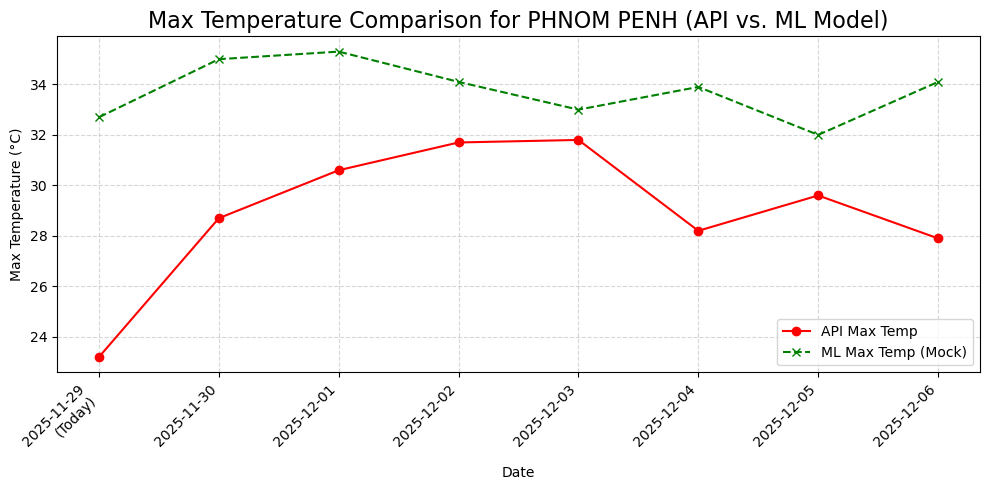

In [5]:
# --- IV. Execution ---

if __name__ == '__main__':
    api_weather = API_FETCHING()
    api_weather.cityoption()